# Задание 3. Python: работа с геоданными

In [1]:
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt

## 1. Загружаем файл

In [2]:
csv_file = gpd.read_file('FastFoodRestaurants.csv')
csv_file.head()

,address,city,country,keys,latitude,longitude,name,postalCode,province,websites,geometry
0,324 Main St,Massena,US,us/ny/massena/324mainst/-1161002137,44.9213,-74.89021,McDonald's,13662,NY,"http://mcdonalds.com,http://www.mcdonalds.com/...",None
1,530 Clinton Ave,Washington Court House,US,us/oh/washingtoncourthouse/530clintonave/-7914...,39.53255,-83.44526,Wendy's,43160,OH,http://www.wendys.com,None
2,408 Market Square Dr,Maysville,US,us/ky/maysville/408marketsquaredr/1051460804,38.62736,-83.79141,Frisch's Big Boy,41056,KY,"http://www.frischs.com,https://www.frischs.com...",None
3,6098 State Highway 37,Massena,US,us/ny/massena/6098statehighway37/-1161002137,44.95008,-74.84553,McDonald's,13662,NY,"http://mcdonalds.com,http://www.mcdonalds.com/...",None
4,139 Columbus Rd,Athens,US,us/oh/athens/139columbusrd/990890980,39.35155,-82.09728,OMG! Rotisserie,45701,OH,"http://www.omgrotisserie.com,http://omgrotisse...",None


In [3]:
csv_file.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   address     10000 non-null  object  
 1   city        10000 non-null  object  
 2   country     10000 non-null  object  
 3   keys        10000 non-null  object  
 4   latitude    10000 non-null  object  
 5   longitude   10000 non-null  object  
 6   name        10000 non-null  object  
 7   postalCode  10000 non-null  object  
 8   province    10000 non-null  object  
 9   websites    10000 non-null  object  
 10  geometry    0 non-null      geometry
dtypes: geometry(1), object(10)
memory usage: 859.5+ KB


## 2. Удалим ненужные поля

Нам нужны только поля latitude, longitude, name, postalCode, province. Остальные можно удалить

In [4]:
csv_file = csv_file.drop(columns=['address', 'city', 'country', 'keys', 'websites'])
csv_file.head()

,latitude,longitude,name,postalCode,province,geometry
0,44.9213,-74.89021,McDonald's,13662,NY,None
1,39.53255,-83.44526,Wendy's,43160,OH,None
2,38.62736,-83.79141,Frisch's Big Boy,41056,KY,None
3,44.95008,-74.84553,McDonald's,13662,NY,None
4,39.35155,-82.09728,OMG! Rotisserie,45701,OH,None


## 3. Проверим, есть ли пропущенные значения

In [5]:
for col in csv_file.columns:
    print(f'{csv_file[col].isna().sum()} missed values in {col}')

0 missed values in latitude
0 missed values in longitude
0 missed values in name
0 missed values in postalCode
0 missed values in province
10000 missed values in geometry


Пропущенных значений нет 

## 4. Преобразовываем типы данных

Приведем поля 'latitude' и 'longitude' к типу float

In [6]:
for col in ['latitude', 'longitude']:
    csv_file[col] = csv_file[col].astype(float)

## 5. Изучим данные

### 5.1 Уникальные значения поля province

In [7]:
csv_file['province'].sort_values().unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'Co Spgs', 'DC', 'DE',
       'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH',
       'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD',
       'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [8]:
csv_file[csv_file['province'] == 'Co Spgs']

,latitude,longitude,name,postalCode,province,geometry
6754,38.795186,-104.802556,Burger King,80906,Co Spgs,None
6797,38.825974,-104.840350,Sonic Drive In,80905,Co Spgs,None
8254,38.812493,-104.822123,Taco Bell,80905,Co Spgs,None
8952,38.836895,-104.817296,Mcdonalds,80903,Co Spgs,None
9198,38.913264,-104.788447,Arby's,80907,Co Spgs,None


'Co Spgs' - не является обозначением штата, это сокращение города Colorado Springs, который находится в штате Colorade (CO). Заменим 'Co Spgs' на 'CO'

In [9]:
csv_file['province'] = csv_file['province'].replace('Co Spgs', 'CO')

### 5.2 Уникальные значения поля postalCode

In [10]:
csv_file['postalCode'].sort_values().unique()

array(['01923-3619', '02111-1318', '02916-2020', ..., '99701', '99709',
       '99801'], dtype=object)

В США почтовый индекс представляет собой либо строку из 5 цифр, либо строку из 5+4 цифр, записанных через дефис. Посмотрим, есть ли в датасете индексы, выпадающие из данного правила.

In [11]:
len(csv_file)

10000

In [12]:
len(csv_file[csv_file.postalCode.apply(lambda x: len(str(x)) == 10)])

115

In [13]:
len(csv_file[csv_file.postalCode.apply(lambda x: len(str(x)) == 5)])

9364

111 + 9318 == 9429 != 9946. Цифры не сходятся. Попробуем посмотреть индексы с длиной 4

In [14]:
len(csv_file[csv_file.postalCode.apply(lambda x: len(str(x)) == 4)])

521

111 + 9318 + 517 == 9946. Все сошлось

In [15]:
len(csv_file[csv_file.postalCode.apply(lambda x: len(str(x)) == 4)])/len(csv_file) * 100

5.21

517 строк составляют больше 5% от общего числа имеющихся строк. Это достаточно большой процент. Не будем удалять данные строки

### 5.3 Поля longitude и latitude

Перед тем как исследовать поля широты и долготы, построим карту миру с точками из датасета с ресторанами.

Зададим geometry из имеющихся latitude и longitude

In [16]:
csv_file = gpd.GeoDataFrame(csv_file, geometry=gpd.points_from_xy(csv_file.longitude, csv_file.latitude), crs="EPSG:4326")

C:\Users\user\anaconda3\lib\site-packages\geopandas\geodataframe.py:35: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)


Используем карту мира, которая "идет в комплекте" с geopandas

C:\Users\user\anaconda3\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
C:\Users\user\anaconda3\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated

<AxesSubplot:>

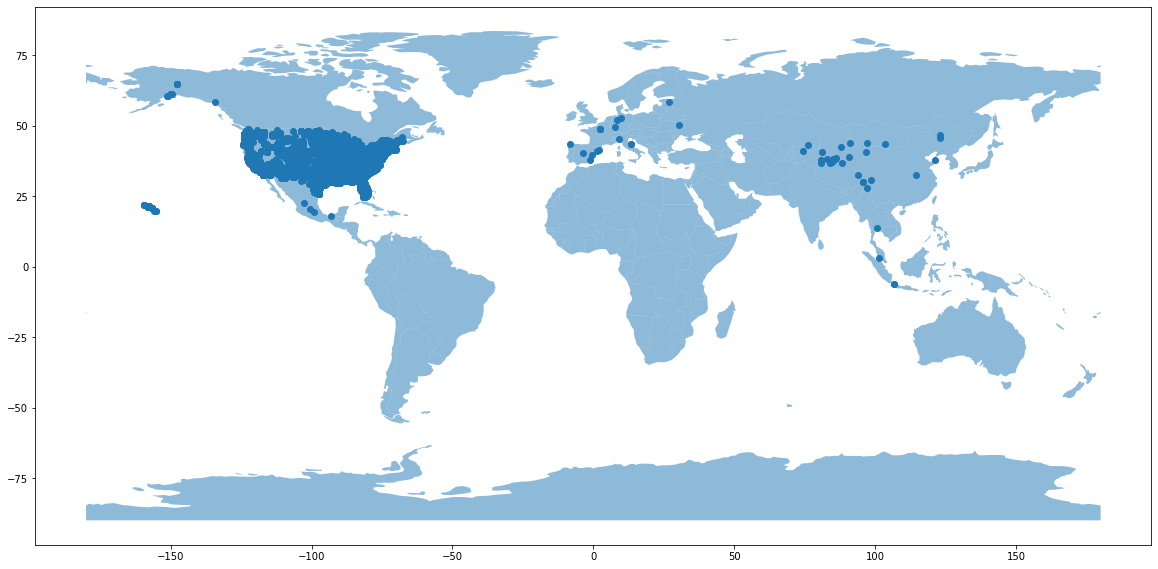

In [17]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
csv_file.plot(ax=world.plot(figsize=(20, 20), alpha=0.5))

Заявляется, что исследуемый датасет описывает рестораны США. Однако, на карте можно увидеть несколько десятков точек, расположенных на территории Европы и Азии, а также несколько точек на территории Мексики.

#### 5.3.1 longitude

In [18]:
csv_file['longitude'].describe()

count    10000.000000
mean       -91.056132
std         18.556339
min       -159.378915
25%        -97.412631
50%        -87.660930
75%        -81.458351
max        123.012361
Name: longitude, dtype: float64

<AxesSubplot:>

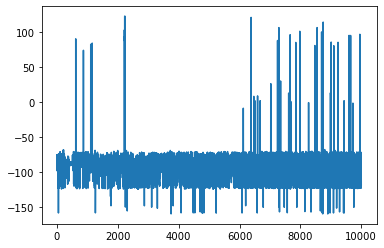

In [19]:
csv_file['longitude'].plot()

#### "Слишком западные"

На графике распределения можно увидеть значения longitude, которые сильно меньше -130. Самый западный штат в США - Гавайи (HI). Посмотрим на строки, у которых longitude < -130 и province не равно 'HI'

In [20]:
csv_file[(csv_file['longitude'] < -130) & (csv_file['province'] != 'HI')]

,latitude,longitude,name,postalCode,province,geometry
1761,58.300580,-134.418406,Domino's Pizza,99801,AK,POINT (-134.41841 58.30058)
1777,64.840240,-147.710430,Domino's Pizza,99701,AK,POINT (-147.71043 64.84024)
2249,61.326200,-149.571800,Arby's,99577,AK,POINT (-149.57180 61.32620)
2873,64.835440,-147.811700,Carl's Jr,99709,AK,POINT (-147.81170 64.83544)
3112,61.203697,-149.744670,McDonald's,99504,AK,POINT (-149.74467 61.20370)
3300,60.559630,-151.235440,McDonalds,99611,AK,POINT (-151.23544 60.55963)
3819,64.836600,-147.755000,Wendy's,99701,AK,POINT (-147.75500 64.83660)
6201,64.840240,-147.710430,Pizza Hut,99701,AK,POINT (-147.71043 64.84024)
6779,61.138939,-149.951375,Subway,99502,AK,POINT (-149.95138 61.13894)
7302,61.226627,-149.740859,Regal Cinemas Tikahtnu 16 IMAX & RPX,99504,AK,POINT (-149.74086 61.22663)


In [47]:
len(csv_file[(csv_file['longitude'] < -130) & (csv_file['province'] != 'HI')])

14

Остались только строки со штатом AK - Аляска. Этот штат является самым западным, не считая Гавайев. Я проверил полученные точки, они действительно находятся на территории Аляски.

#### "Слишком восточные"

На графике распределения longitude очень много значений, которые больше -50. На карте мира эти точки расположены в Евразии. Посмотрим, сколько всего таких строк.

In [21]:
len(csv_file[csv_file['longitude'] > -50])

50

Всего точек, находящихся в Евразии - 50. Удалим их.

In [22]:
csv_file = csv_file[~(csv_file['longitude'] > -50)]

Посмотрим на карту мира еще раз

C:\Users\user\anaconda3\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
C:\Users\user\anaconda3\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated

<AxesSubplot:>

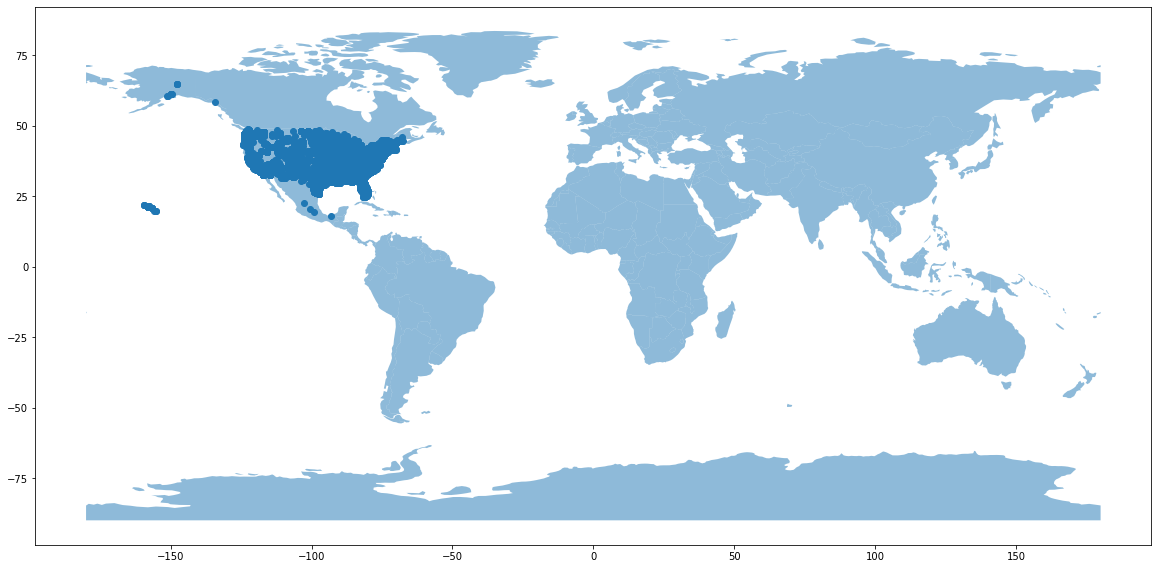

In [23]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
csv_file.plot(ax=world.plot(figsize=(20, 20), alpha=0.5))

Теперь нужно разобраться с точками в Мексике и проверить северные точки.

#### latitude

In [24]:
csv_file['latitude'].describe()

count    9950.000000
mean       37.550089
std         4.982699
min        17.989019
25%        34.026560
50%        38.289085
75%        41.103758
max        64.840240
Name: latitude, dtype: float64

<AxesSubplot:>

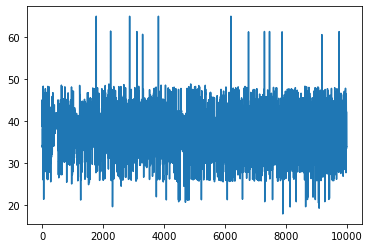

In [25]:
csv_file['latitude'].plot()

#### "Слишком северные"

На графике распределения мы видим несколько точек, где latitude превосходит 50. Изучим их.

In [44]:
csv_file[csv_file['latitude'] > 50]

,latitude,longitude,name,postalCode,province,geometry
1761,58.300580,-134.418406,Domino's Pizza,99801,AK,POINT (-134.41841 58.30058)
1777,64.840240,-147.710430,Domino's Pizza,99701,AK,POINT (-147.71043 64.84024)
2249,61.326200,-149.571800,Arby's,99577,AK,POINT (-149.57180 61.32620)
2873,64.835440,-147.811700,Carl's Jr.,99709,AK,POINT (-147.81170 64.83544)
3112,61.203697,-149.744670,McDonald's,99504,AK,POINT (-149.74467 61.20370)
3300,60.559630,-151.235440,McDonald's,99611,AK,POINT (-151.23544 60.55963)
3819,64.836600,-147.755000,Wendy's,99701,AK,POINT (-147.75500 64.83660)
6201,64.840240,-147.710430,Pizza Hut,99701,AK,POINT (-147.71043 64.84024)
6779,61.138939,-149.951375,SUBWAY,99502,AK,POINT (-149.95138 61.13894)
7302,61.226627,-149.740859,Regal Cinemas Tikahtnu 16 IMAX & RPX,99504,AK,POINT (-149.74086 61.22663)


In [46]:
len(csv_file[csv_file['latitude'] > 50])

14

Это те же самые точки на территории Аляски (AK), что мы уже видели в разделе "Слишком западные", их я уже проверял, они корректные.

#### "Слишком южные"

На карте мира есть несколько точек, расположенных на территории Мексики. Самый южный штат в США - это Гавайи (код HI).  Отсортируем строки по широте, и посмотрим те, у которых широта минимальна, и при этом они не находятся в Гавайях

In [28]:
csv_file[csv_file['province'] != 'HI'].sort_values('latitude').head(10)

,latitude,longitude,name,postalCode,province,geometry
7906,17.989019,-92.965096,Subway,86038,AZ,POINT (-92.96510 17.98902)
9099,19.345262,-99.149852,Kfc,4040,ME,POINT (-99.14985 19.34526)
9079,20.578696,-100.418923,Burger King,76177,TX,POINT (-100.41892 20.57870)
8142,22.776771,-102.597749,Subway,98040,WA,POINT (-102.59775 22.77677)
2595,24.560301,-81.780278,Burger King,33040,FL,POINT (-81.78028 24.56030)
4655,24.564621,-81.771767,Five Guys,33040,FL,POINT (-81.77177 24.56462)
4662,24.715753,-81.079115,Wendy's,33050,FL,POINT (-81.07912 24.71575)
4661,24.716362,-81.073312,McDonald's,33050,FL,POINT (-81.07331 24.71636)
4663,24.718164,-81.067184,KFC,33050,FL,POINT (-81.06718 24.71816)
4660,24.718180,-81.067190,Taco Bell,33050,FL,POINT (-81.06719 24.71818)


В глаза бросаются первые 4 строки, широта которых отличается на 2 и 4, 5 и 7 градусов от широты последующих строк. Я проверил координаты этих точек - они действительно находятся на территории Мексики. Удалим их.

In [29]:
csv_file = csv_file.drop(index=[7906, 9099, 9079, 8142])

Посмотрим на карту мира еще раз

C:\Users\user\anaconda3\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
C:\Users\user\anaconda3\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated

<AxesSubplot:>

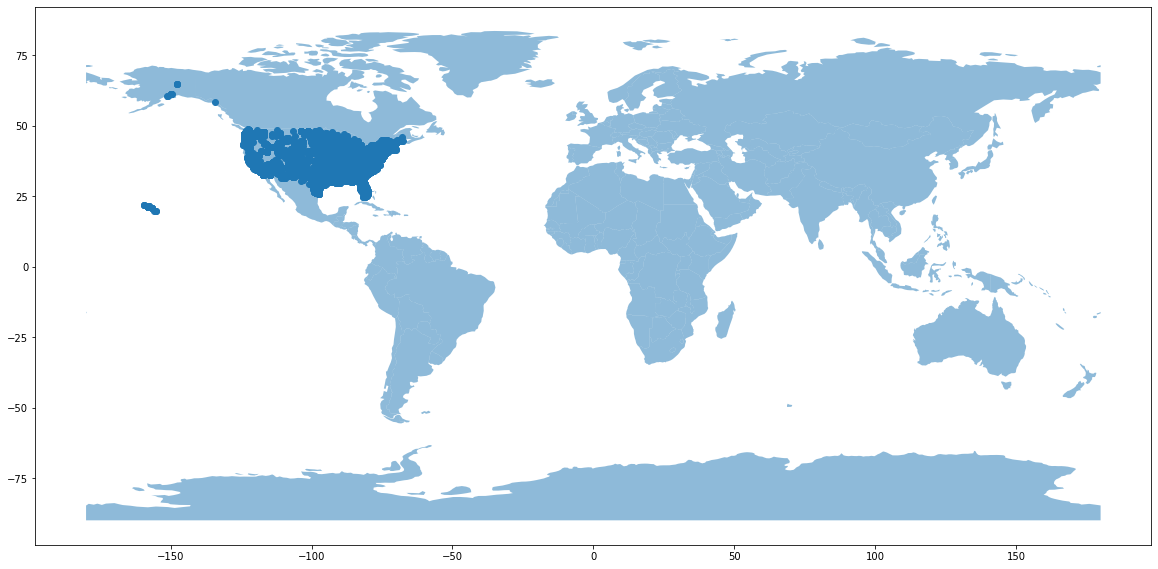

In [30]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
csv_file.plot(ax=world.plot(figsize=(20, 20), alpha=0.5))

Теперь все в порядке!

### 5.4 Поле name

In [31]:
csv_file['name'].sort_values().unique()

array(['31st Avenue Gyro', '7-11', '7-Eleven', 'A & W Family Restaurant',
       'A&W', 'A&W All American Food', 'A&W All-American Food',
       'A&W All-American Foods', 'A&W Restaurant',
       'A&W/Long John Silvers', 'A&w', 'A&w Restaurant',
       "AJ's Hotdogs & Gyros", 'Ama Ristorante', 'Amigos/Kings Classic',
       'Aprisa Mexican Cuisine', "Arby's", "Arby's Antigo", 'Arbys',
       'Arctic Circle', 'Au Bon Pain', "Auntie Anne's", 'Aw Restaurant',
       'B K', 'B Z Breakfast Burgers Beyond', 'B. Good',
       'BGR - The Burger Joint', "BIG & little's Restaurant", 'BLIMPIE',
       'Back Yard Burgers', 'Backyard Burgers', 'Bad Daddys Burger Bar',
       'Baja Fresh', 'Baja Fresh Mexican Grill', "Baker's Drive Thru",
       'Ball State Lafollette Dining', 'Bamboo Bistro', 'Baskin-Robbins',
       'Bb&t', "Ben & Jerry's", 'Bills Place', "Blake's LotaBurger",
       "Blake's Lotaburger", 'Blakes Lotaburger', 'Blimpie',
       'Blimpie Subs & Sandwiches', 'Blondies', 'Bob Evans',


Можем увидеть, что в поле name встречаются значения, похожие друг на друга, например:  
'A&W' и 'A&w';  
'A&W All American Food', 'A&W All-American Food' и 'A&W All-American Foods';  
'A&W Restaurant', 'A&w Restaurant';  
"Mc Donald's", 'Mc Donalds', "McDonald's", "McDonald's of Mililani Mauka", 'McDonalds', 'McDonalds @ Old Atlanta', 'McDonaldвЂ™s' и т.д.
         

Воспользуемся NLP-библиотекой nltk, чтобы найти все похожие друг на друга названия при помощи функции edit_distance, вычисляющей расстояние Левенштейна между двумя словами. Установим: если расстояние между двумя словами < 4, считаем эти слова похожими.  
Расстояние Левенштейна - минимальное количество односимвольных операций (а именно вставки, удаления, замены), необходимых для превращения одной последовательности символов в другую

In [32]:
import nltk

# obtained unique names of restaurants
restaurant_names = csv_file['name'].unique()

# calculate similarity and record most-similar names together
most_similar = []
for i in range(len(restaurant_names)):
    # temporary list to store the current similar words
    temp_similar = [restaurant_names[i]]
    
    # compare and save similar words
    for j in range(len(restaurant_names)):
        if restaurant_names[i] == restaurant_names[j]:
            continue
        if nltk.edit_distance(restaurant_names[i].lower(), restaurant_names[j].lower()) < 4:
            temp_similar.append(restaurant_names[j])
            
    # similar word(s) found
    if len(temp_similar) > 1:
        most_similar.append(temp_similar)
    if i > 0 and i % 100 == 0:
        print(i-100, "-", i, "similarity checking finished. most_similar size:", len(most_similar))
print("Similarity checking finished")

# count number of similar words
most_similar_word_count = 0
for i in most_similar:
    most_similar_word_count += len(i)
print("Number of words in most similar list:", most_similar_word_count)
most_similar

0 - 100 similarity checking finished. most_similar size: 54
100 - 200 similarity checking finished. most_similar size: 87
200 - 300 similarity checking finished. most_similar size: 119
300 - 400 similarity checking finished. most_similar size: 141
400 - 500 similarity checking finished. most_similar size: 164
Similarity checking finished
Number of words in most similar list: 495


[["McDonald's",
  'McDonalds',
  "Mcdonald's",
  "Mc Donald's",
  'Mcdonalds',
  'Mc Donalds',
  'McDonaldвЂ™s'],
 ["Wendy's", 'Wendys', "Grandy's"],
 ["Domino's Pizza", 'Dominos Pizza', "Nino's Pizza"],
 ['Pizza Hut', 'Pizza One'],
 ['SONIC Drive In',
  'Sonic Drive-In',
  'SONIC Drive-In',
  'Sonic Drive In',
  'Sonic Drive in',
  'Sonic Drive-in'],
 ["Long John Silver's", 'Long John Silvers'],
 ['Taco Bell', 'Taco Bueno'],
 ['Sonic Drive-In',
  'SONIC Drive In',
  'SONIC Drive-In',
  'Sonic Drive In',
  'Sonic Drive in',
  'Sonic Drive-in'],
 ["Taco John's", "Papa John's"],
 ['Whataburger', 'Fatburger'],
 ['Hamburger King', 'Burger King'],
 ['Burger King', 'Hamburger King', 'Burger Time'],
 ['McDonalds',
  "McDonald's",
  "Mcdonald's",
  "Mc Donald's",
  'Mcdonalds',
  'Mc Donalds',
  'McDonaldвЂ™s'],
 ['Taco Time', 'TacoTime'],
 ["Jimmy John's", 'Jimmy Johns'],
 ['Popeyes Louisiana Kitchen', "Popeye's Louisiana Kitchen"],
 ["Hardee's", 'Hardees'],
 ["Rally's", "Arby's", 'Rallys', "

Мы можем увидеть, что некоторые подмножества были ошибочно определены как похожие (например, ["Arby's", "Luby's", 'Arbys', "Zaxby's"]).  
Также есть повторяющиеся списки, которые отличаются порядком элементов внутри них.  
Отсортируем каждый список-подмножество, а затем отсортируем все списки по первому элементу

In [33]:
most_similar = [sorted(x) for x in most_similar]
most_similar.sort(key=lambda x: x[0])
most_similar

[['A&W', 'A&w', 'B K', 'KFC', 'Kfc'],
 ['A&W', 'A&w', 'B K', 'KFC', 'Kfc'],
 ['A&W', 'A&w', 'B K', 'Bb&t', 'KFC', 'Kfc'],
 ['A&W', 'A&w', 'B K', 'Bb&t'],
 ['A&W', 'A&w', 'B K', 'Bb&t', 'KFC', 'Kfc'],
 ['A&W', 'A&w', 'B K', 'Bb&t', 'Fuku', 'KFC', 'Kfc'],
 ['A&W All American Food', 'A&W All-American Food', 'A&W All-American Foods'],
 ['A&W All American Food', 'A&W All-American Food', 'A&W All-American Foods'],
 ['A&W All American Food', 'A&W All-American Food', 'A&W All-American Foods'],
 ['A&W Restaurant', 'A&w Restaurant', 'Aw Restaurant'],
 ['A&W Restaurant', 'A&w Restaurant', 'Aw Restaurant'],
 ['A&W Restaurant', 'A&w Restaurant', 'Aw Restaurant'],
 ["Arby's", "Grandy's", "Rally's", 'Rallys', "Rocky's", "Zaxby's"],
 ["Arby's", 'Arbys', "Luby's", "Rally's", "Zaxby's"],
 ["Arby's",
  'Arbys',
  "Furr's",
  "Love's",
  "Luby's",
  "Rubio's",
  "Rush's",
  "Zaxby's"],
 ["Arby's", 'Arbys', "Luby's", 'Rallys', "Zaxby's"],
 ["Arby's", 'Arbys', "Luby's", "Rally's", "Zaxby's"],
 ['Arbys', "Ra

Теперь удалим дублирующиеся списки-подмножества

In [34]:
import itertools
most_similar = list(most_similar for most_similar,_ in itertools.groupby(most_similar))
most_similar

[['A&W', 'A&w', 'B K', 'KFC', 'Kfc'],
 ['A&W', 'A&w', 'B K', 'Bb&t', 'KFC', 'Kfc'],
 ['A&W', 'A&w', 'B K', 'Bb&t'],
 ['A&W', 'A&w', 'B K', 'Bb&t', 'KFC', 'Kfc'],
 ['A&W', 'A&w', 'B K', 'Bb&t', 'Fuku', 'KFC', 'Kfc'],
 ['A&W All American Food', 'A&W All-American Food', 'A&W All-American Foods'],
 ['A&W Restaurant', 'A&w Restaurant', 'Aw Restaurant'],
 ["Arby's", "Grandy's", "Rally's", 'Rallys', "Rocky's", "Zaxby's"],
 ["Arby's", 'Arbys', "Luby's", "Rally's", "Zaxby's"],
 ["Arby's",
  'Arbys',
  "Furr's",
  "Love's",
  "Luby's",
  "Rubio's",
  "Rush's",
  "Zaxby's"],
 ["Arby's", 'Arbys', "Luby's", 'Rallys', "Zaxby's"],
 ["Arby's", 'Arbys', "Luby's", "Rally's", "Zaxby's"],
 ['Arbys', "Rally's", 'Rallys'],
 ['B K', 'Fuku'],
 ['B. Good', 'b.good'],
 ['BLIMPIE', 'Blimpie'],
 ['Back Yard Burgers', 'Backyard Burgers'],
 ["Ben & Jerry's", "Tom & Jerry's"],
 ["Blake's LotaBurger", "Blake's Lotaburger", 'Blakes Lotaburger'],
 ['Burger King', 'Hamburger King'],
 ['Burger King', 'Burger Time', 'Hamb

Остались "почти дублирующиеся" списки-подмножества. Объединим их вручную и удалим из списка похожих слов те, которые на самом деле являются названиями разных ресторанов (например, ["Arby's", "Luby's", 'Arbys', "Zaxby's"]).  
Также объединим названия, которые формально сильно отличаются, но по факту являются названием одного и того же ресторана, например, 'A&W', 'A&W All American Food' и 'A&W Restaurant'; или 'KFC' и 'KFC - Kentucky Fried Chicken'; или 'Papa Johns' и "Papa John's Pizza", и т.д.  
Также добавим из оригинального множества имен ресторанов похожие (например, McDonald's of Mililani Mauka к подмножеству McDonald's.
Объединим "Charley's Grilled Subs" и 'Charleys Philly Steaks' и пр. Полный список объединений см. ниже

In [35]:
most_similar = [
    ['A&W', 'A&w', 'A&W All American Food', 'A&W All-American Food', 'A&W All-American Foods', 
     'A&W Restaurant', 'A&w Restaurant', 'Aw Restaurant'],
    ["Arby's", 'Arbys', "Arby's Antigo"],
    ['B. Good', 'b.good'],
    ['BLIMPIE', 'Blimpie', 'Blimpie Subs & Sandwiches'],
    ['Back Yard Burgers', 'Backyard Burgers'],
    ['Baja Fresh', 'Baja Fresh Mexican Grill'],
    ["Blake's LotaBurger", "Blake's Lotaburger", 'Blakes Lotaburger'],
    ['Bob Evans', 'Bob Evans Restaurant'],
    ['Boston Market', 'Boston Market 381'],
    ["Braum's", "Braum's Ice Cream & Dairy Store"],
    ['Burgerville', 'Burgerville, USA'], 
    ["Captain D's", "Captain D's Seafood"], 
    ["Carl's Jr. / Green Burrito", "Carl's / Green Burrito", "Carl's Jr - Green Burrito", "Carl's Jr / Green Burrito",
     'Carls Jr. / Green Burrito', 'Dual - Carls / Grn Burrito 1100654'],
    ["Carl's Jr.", "Carl's Jr", 'Carls Jr'],
    ["Charley's Grilled Subs", 'Charleys Philly Steaks'],
    ["Checker's", 'Checkers', "Checker's Drive-in Restaurant", "Checker's Hamburgers", 'Checkers Burgers and Fries'],
    ['Chick-Fil-A', 'Chick-fil-A', 'Chick-fil-a', 'Chick-fil-a Magnolia Mall', 'Chick-fil-a Orange Avenue', 
     'Chick-fil-a Superstition Springs Center', "Chick-fil-a Truett's Luau"],
    ['China King', 'China King Restaurant'],
    ['Cook Out', 'Cook-Out', 'Cookout'],
    ['Costa Vida', 'Costa Vida Fresh Mexican Grill'],
    ["Culver's", 'Culvers'],
    ["D'Angelo Grilled Sandwiches", "D'angelo Grilled Sandwiches"],
    ['DQ Grill & Chill', 'Dq Grill & Chill', 'DQ Woodlands', 'Dairy Queen', 'Dairy Queen - Round Rock', 
     'Dairy Queen Grill & Chill'],
    ['DQ Grill & Chill / Orange Julius', 'Dairy Queen Grill & Chill / Orange Julius'],
    ["Domino's Pizza", 'Dominos Pizza'],
    ['Dunkin Donuts', "Dunkin' Donuts"],
    ["Foster's Freeze", 'Fosters Freeze'],
    ["Frugal's", 'Frugals'],
    ['Great Steak & Potato Co', 'Great Steak And Potato Co', 'Great Steak'],
    ["Hardee's", 'Hardees'],
    ['Home Town Buffet', 'Hometown Buffet'],
    ['Hot Dog On A Stick', 'Hot Dog on a Stick'],
    ['Jack In The Box', 'Jack in the Box'],
    ["Jimmy John's", 'Jimmy Johns', "Jimmy John's Gourmet Sandwiches"],
    ['KFC', 'Kfc', 'KFC - Kentucky Fried Chicken', 'Kfc - Kentucky Fried Chicken'],
    ['KFC / Taco Bell', 'KFC/Taco Bell'],
    ['Kum & Go', 'Kum Go'],
    ['L&L Hawaiian Barbecue', 'L&l Hawaiian Barbecue', 'Ll Hawaiian Barbecue'],
    ['Little Caesars Pizza', "Little Caesar's Pizza Smithfield"],
    ["Long John Silver's", 'Long John Silvers'],
    ["Long John Silver's / A&W", 'Long John Silver/ A&W', 'Long John Silvers / A&W'],
    ["McDonald's", "Mc Donald's", 'Mc Donalds', 'McDonalds', 'McDonaldвЂ™s', "Mcdonald's", 'Mcdonalds', 
     "McDonald's of Mililani Mauka", 'McDonalds @ Old Atlanta', "Mcdonald's #25557", "Mcdonald's - Walmart"],
    ['Mr. Hero', 'Mr Hero'],
    ["Papa John's", 'Papa Johns', "Papa John's Pizza", 'Papa Johns Pizza', 'Papa JohnвЂ™s Pizza'],
    ['Pizza Hut', 'Pizza Hut Wingstreet'],
    ["Popeye's", 'Popeyes', "Popeye's Chicken & Biscuits", 'Popeyes Chicken & Biscuits', "Popeye's Chicken & Biscuits",
     'Popeyes Chicken & Biscuits', 'Popeyes Chicken and Biscuits', "Popeye's Louisiana Kitchen", 'Popeyes Louisiana Kitchen',
     'Popeyes Chicken & Biscuits', 'Popeyes Chicken and Biscuits'],
    ['Port Of Subs', 'Port of Subs'],
    ['QDOBA Mexican Eats', 'Qdoba Mexican Eats', 'Qdoba Mexican Grill'],
    ["Quizno's +", 'Quiznos', 'Quiznos Sub'],
    ["Raising Cane's", "Raising Cane's Chicken Fingers"],
    ["Rally's", "Rally's Hamburgers", "Rally's Springfield", 'Rallys'],
    ["Rubio's", "Rubio's Coastal Grill"],
    ['SONIC Drive-In', 'SONIC Drive In', 'Sonic Drive In', 'Sonic Drive in', 'Sonic Drive-In', 'Sonic Drive-in', 'Sonic'],
    ['SUBWAY', 'SUBWAYВ®', 'Subway', 'Subway (johnson) @ Jonesboro', "Subway - Bell's Ferry", 'Subway - Roland Park', 
     'Subway Citgo of Quarryville', 'Subway Sandwiches', 'Subway Sandwiches and Salads'],
    ["Spangle's", 'Spangles'],
    ["Steak 'N Shake", "Steak 'n Shake", 'Steak N Shake'],
    ['Taco Del Mar', 'Taco del Mar'],
    ['Taco Time', 'TacoTime'],
    ["Thrasher's French Fries", 'Thrashers French Fries'],
    ["Topper's Pizza", 'Toppers Pizza'],
    ["Wendy's", 'Wendys']
]

Теперь создадим словарь, на основе которого заменим названия ресторанов

In [36]:
name_dict = {}
for row in most_similar:
    for word in row:
        name_dict[word] = row[0]
name_dict

{'A&W': 'A&W',
 'A&w': 'A&W',
 'A&W All American Food': 'A&W',
 'A&W All-American Food': 'A&W',
 'A&W All-American Foods': 'A&W',
 'A&W Restaurant': 'A&W',
 'A&w Restaurant': 'A&W',
 'Aw Restaurant': 'A&W',
 "Arby's": "Arby's",
 'Arbys': "Arby's",
 "Arby's Antigo": "Arby's",
 'B. Good': 'B. Good',
 'b.good': 'B. Good',
 'BLIMPIE': 'BLIMPIE',
 'Blimpie': 'BLIMPIE',
 'Blimpie Subs & Sandwiches': 'BLIMPIE',
 'Back Yard Burgers': 'Back Yard Burgers',
 'Backyard Burgers': 'Back Yard Burgers',
 'Baja Fresh': 'Baja Fresh',
 'Baja Fresh Mexican Grill': 'Baja Fresh',
 "Blake's LotaBurger": "Blake's LotaBurger",
 "Blake's Lotaburger": "Blake's LotaBurger",
 'Blakes Lotaburger': "Blake's LotaBurger",
 'Bob Evans': 'Bob Evans',
 'Bob Evans Restaurant': 'Bob Evans',
 'Boston Market': 'Boston Market',
 'Boston Market 381': 'Boston Market',
 "Braum's": "Braum's",
 "Braum's Ice Cream & Dairy Store": "Braum's",
 'Burgerville': 'Burgerville',
 'Burgerville, USA': 'Burgerville',
 "Captain D's": "Captain 

In [37]:
len(csv_file['name'].unique())

540

Количество уникальных наименований ресторанов до замены: 540

In [38]:
csv_file = gpd.GeoDataFrame(csv_file).replace({'name': name_dict})

In [39]:
len(csv_file['name'].unique())

412

Количество уникальных наименований ресторанов после замены: 412

## 6. Процент каждого типа ресторана в штате

In [75]:
province_rest = csv_file.groupby(['province', 'name']).agg({'name': 'count'})
province = csv_file.groupby('province').agg({'name': 'count'})
rest_percent_by_province = province_rest.div(province, level='province')
rest_percent_by_province.rename(columns={'name': 'rest_percentage'}, inplace=True)
rest_percent_by_province

rest_percentage
province name                           
AK       Arby's                 0.214286
         Carl's Jr.             0.071429
         Domino's Pizza         0.142857
         McDonald's             0.214286
         Pizza Hut              0.142857
...                                  ...
WY       SONIC Drive-In         0.048780
         SUBWAY                 0.170732
         Taco Bell              0.097561
         Taco John's            0.048780
         Wendy's                0.073171

[1526 rows x 1 columns]

In [92]:
rest_percent_by_province.sort_values('rest_percentage', ascending=False).head()

,,rest_percentage
province,name,
CT,McDonald's,0.395833
VT,McDonald's,0.395349
ME,McDonald's,0.279070
NY,McDonald's,0.271698
LA,McDonald's,0.262712


ТОП-5 самых высоких процентов среди всех ресторанов в штате у McDonald's.

## 7. Количество уникальных почтовых идексов по штатам

In [42]:
count_postal_codes = csv_file.groupby(['province']).nunique()['postalCode']
count_postal_codes

C:\Users\user\anaconda3\lib\site-packages\geopandas\array.py:969: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return from_wkb(values)


province
AK     11
AL    128
AR     72
AZ    115
CA    427
CO     93
CT     47
DC     13
DE     16
FL    286
GA    195
HI     21
IA     73
ID     33
IL    204
IN    159
KS     65
KY    117
LA     91
MA     91
MD     91
ME     22
MI    147
MN     82
MO    146
MS     31
MT     17
NC    179
ND     17
NE     45
NH     23
NJ     99
NM     52
NV     48
NY    186
OH    245
OK     99
OR     74
PA    178
RI     19
SC    120
SD     25
TN    144
TX    399
UT     72
VA    157
VT     15
WA    102
WI    100
WV     46
WY     17
Name: postalCode, dtype: int64

In [43]:
count_postal_codes.sort_values(ascending=False).head()

province
CA    427
TX    399
FL    286
OH    245
IL    204
Name: postalCode, dtype: int64

Наибольшее количество уникальных почтовых индексов в штатах:
1. CA - Калифорния  
2. TX - Техас  
3. FL - Флорида  
4. OH - Огайо
5. IL - Иллинойс

## 8. Объединяем точки ресторанов в полигоны

In [159]:
rest_polygons = gpd.GeoDataFrame(columns=['province', 'geometry'])
rest_polygons['province'] = csv_file['province'].unique()

polygons = []
for state in csv_file['province'].unique():
    poly = geometry.Polygon([[p.x, p.y] for p in csv_file[csv_file['province'] == state].geometry])
    polygons.append(poly)
rest_polygons['geometry'] = polygons

In [161]:
rest_polygons

,province,geometry
0,NY,"POLYGON ((-74.89021 44.9213, -74.84553 44.9500..."
1,OH,"POLYGON ((-83.44526 39.53255, -82.09728 39.351..."
2,KY,"POLYGON ((-83.79141 38.62736, -84.53043 38.067..."
3,SC,"POLYGON ((-81.7704 34.00598, -81.5333 33.91335..."
4,AR,"POLYGON ((-90.52325 36.06107, -92.407839999999..."
5,OK,"POLYGON ((-97.5382 35.52234, -97.61717 35.5481..."
6,IN,"POLYGON ((-86.76211499999999 37.941032, -87.57..."
7,NC,"POLYGON ((-77.99544 34.23389, -78.02454 34.211..."
8,TN,"POLYGON ((-86.77995 36.04222, -89.84786 35.226..."
9,TX,"POLYGON ((-98.50064999999999 33.85371, -97.164..."


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


<AxesSubplot:>

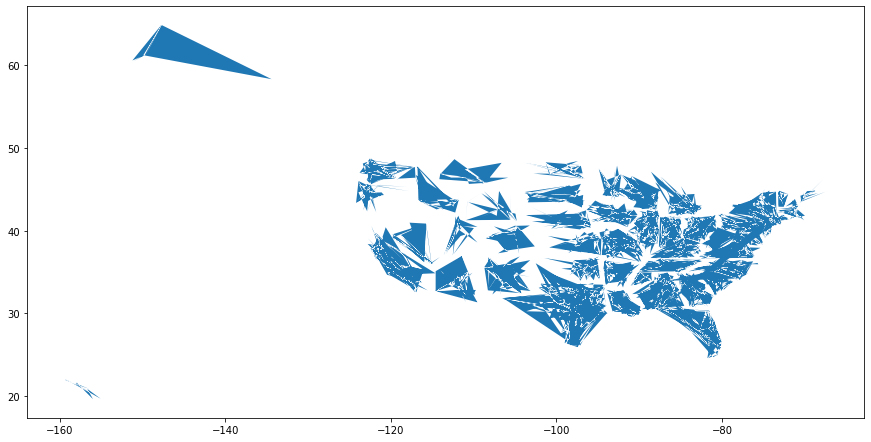

In [167]:
rest_polygons.plot(figsize=(15,20))

In [168]:
csv_file[['province', 'geometry']]

,province,geometry
0,NY,POINT (-74.89021 44.92130)
1,OH,POINT (-83.44526 39.53255)
2,KY,POINT (-83.79141 38.62736)
3,NY,POINT (-74.84553 44.95008)
4,OH,POINT (-82.09728 39.35155)
...,...,...
9995,GA,POINT (-82.02453 33.41526)
9996,IL,POINT (-88.25580 42.21730)
9997,CO,POINT (-105.10172 40.18919)
9998,CA,POINT (-116.48215 33.78864)


## 9. Экспортируем в kml

In [169]:
import fiona

fiona.supported_drivers['KML'] = 'rw'

rest_points = csv_file[['province', 'geometry']]

rest_points.to_file('rest_points.kml', driver='KML')
rest_polygons.to_file('rest_by_states_polygons.kml', driver='KML')